In [5]:
###SASSIE UPTEMPO HYDROGRAPHY BUOY DATA USE AND VISUALIZATION##
import numpy as np
import xarray as xr
import glob 
from datetime import datetime, timedelta 
import matplotlib.pyplot as plt
import cartopy
import matplotlib
import os
import sys
import pandas as pd
import requests

##LOCAL DIRECTORY TO UpTempO DATA
dir_in = '/Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/L2/UpTempO/'

##LOCAL DIRECTORY TO SHIP TRACK DATA
ship_dir = '/Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/L2/TSG/SASSIE_Fall_2022_Shipboard_TSG.nc'
    
##LOCAL DIRECTORY TO SAVE FIGURES
fig_dir = '/Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/uptempo/'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

##READ IN BATHYMETRY DATA
url = 'http://ferret.pmel.noaa.gov/thredds/dodsC/data/PMEL/etopo2.nc'
etopodata = xr.open_dataset(url)

In [6]:
##LOAD IN THE NETCDF FILES AND LOOK AT THEIR METADATA  
files = sorted(glob.glob(dir_in + '/*.nc'))
for file in files:
    
    ##SHOWS THE GLOBAL METEADATA AND WHICH VARIABLES ARE IN THE FILE
    ds = xr.open_dataset(file)
    #print(ds)
    
    ##SHOW THE VARIABLE ATTRIBUTES FOR ANY GIVEN VARIABLE WITHIN THE FILE. Replace "salinity" with your variable of interest:
    variable_info = ds.time
    #print(variable_info)

In [7]:
##USE THIS TO PLOT THE UPTEMPO TRACKS ON A MAP. ENTER 'all_data' TO MAP ALL UPTEMPO DATA AND 'campaign_data' TO MAP ONLY DATA TAKEN DURRING CAMPIGN.  
def map_uptempo(map_view,ship_track=True,bathymetry_data=True):
    
    ##TIME DATA FROM BOUY 01 (deployed on September 9th and was still collecting data as of 03/13) 
    files = sorted(glob.glob(dir_in + '/*.nc'))
    ds = xr.open_dataset(files[3])
    time = np.squeeze(ds['time'].values)
    start_time = min(time)
    end_time = max(time)
        
    ##CREATE A MAP WITH LAND AND CITY MARKERS AND SHIP TRACK  
    if map_view == 'all_data':
        latmin = 70
        latmax =80
        lonmin=-177
        lonmax=-145
        var_min = start_time.astype('int64')
        var_max =end_time.astype('int64')
    if map_view == 'campaign_data':
        latmin = 70
        latmax =74
        lonmin=-157
        lonmax=-145
        ds_ship = xr.open_dataset(ship_dir)
        ship_time = np.squeeze(ds_ship['time'])
        var_min = min(ship_time.values).astype('int64')
        var_max = max(ship_time.values).astype('int64')
        
    campaign_start = datetime(2022,9,8,8)
    campaign_end = datetime(2022,9,29)
        
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection=cartopy.crs.NorthPolarStereo(central_longitude=-150))
    ax.set_extent([lonmin,lonmax,latmin,latmax], crs=cartopy.crs.PlateCarree())
    ax.coastlines(color='k')  
    ax.add_feature(cartopy.feature.LAND, facecolor = '0.50')
    ax.add_feature(cartopy.feature.RIVERS,facecolor='blue')

    
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.3)
    if map_view =='all_data':
        ax.set_title('UpTempO Hydrography Buoy Tracks',fontsize=20,pad=1) 
    if map_view == 'campaign_data':
        ax.set_title('UpTempO Hydrography Buoy Tracks Throughout SASSIE Campaign',fontsize=15,pad=1.5) 
    gl.ylocator = matplotlib.ticker.FixedLocator(np.arange(60,82,1))
    gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(-180,180,2))
    gl.top_labels = False
    gl.bottom_labels = True
    gl.right_labels = False
    
    if (latmin<71.2906) & (lonmin<-156.7886):
        utqiagvik = ax.scatter(-156.7886,71.2906,s=100,transform=cartopy.crs.PlateCarree(),c='red',marker = '*',label='Utqiagvik, AK',zorder=2)
    if (latmin<70.2002) & (lonmax>-148.4597):
        deadhorse = ax.scatter(-148.4597,70.2002,s=100,c='cyan',transform=cartopy.crs.PlateCarree(),marker = '*',label='Deadhorse, AK',zorder=2)
    plt.legend(loc=3)
    

    if ship_track==True:
        #ADD SHIP TRACK DATA
        ds_ship = xr.open_dataset(ship_dir)
        ship_time = np.squeeze(ds_ship['time'])
        ship_lat = np.squeeze(ds_ship['latitude'])
        ship_lon = np.squeeze(ds_ship['longitude'])
        track = ax.plot(ship_lon, 
                     ship_lat,linewidth = 0.5,
                     c='black',
                       transform=cartopy.crs.PlateCarree(),label = 'Ship Track',zorder=1)
        plt.legend(loc=3)
    
    if bathymetry_data == True:    
        ##ADD BATHYMETRY DATA
        topoin = etopodata.rose.values[0:-1:5,1:-1:5]
        lons = etopodata.etopo2_x.values[0:-1:5]
        lats = etopodata.etopo2_y.values[0:-1:5]
        lons_in_range = lons[np.where((lons >lonmin-1) & (lons<lonmax+1))]
        lats_in_range = lats[np.where((lats >latmin-1) & (lats<latmax+1))]
        topo_in_range = np.squeeze(topoin[np.squeeze(np.where((lats >latmin-1) & (lats<latmax+1))),:][:,np.where((lons >lonmin-1) & (lons<lonmax+1))])
        [bathy_lon,bathy_lat] = np.meshgrid(lons_in_range,lats_in_range)

        bathy = ax.contour(bathy_lon,bathy_lat,topo_in_range,np.arange(-6000,-1000,300),transform=cartopy.crs.PlateCarree(),cmap='gray',alpha = 0.2,zorder = 0)
        
    
    ##APPLY THE TIME AND LOCATION DATA IN EACH UPTEMPO FILE 
    files = sorted(glob.glob(dir_in + '/*.nc'))
    if map_view == 'all_data':
        for file in files:
            ds_ut = xr.open_dataset(file)
            ut_time = np.squeeze(ds_ut['time'])
            ut_lat = np.squeeze(ds_ut['latitude'])
            ut_lon = np.squeeze(ds_ut['longitude'])

            deployment_track = ax.scatter(ut_lon,ut_lat,s = 1,
                           c = ut_time,cmap = 'jet',
                           transform=cartopy.crs.PlateCarree(),zorder=2,vmin=var_min,vmax=var_max)



        cbar = fig.colorbar(deployment_track, ax=ax, orientation="horizontal", pad=0.1)
        cbar.set_label(label='Date',size='large',weight='bold')
        cbar_tick_array=(np.linspace(start_time.astype('int64'),end_time.astype('int64'),5))
        cbar.set_ticks(cbar_tick_array)
        cbar.set_ticklabels(pd.to_datetime(cbar_tick_array).date)  
    if map_view == 'campaign_data':
        for file in files:
            ds_ut = xr.open_dataset(file)
            ds_ut_campaign = ds_ut.sel(time=slice(campaign_start,campaign_end))
            ut_time = np.squeeze(ds_ut_campaign['time'])
            ut_lat = np.squeeze(ds_ut_campaign['latitude'])
            ut_lon = np.squeeze(ds_ut_campaign['longitude'])

            deployment_track = ax.scatter(ut_lon,ut_lat,s = 1,
                           c = ut_time,cmap = 'jet',
                           transform=cartopy.crs.PlateCarree(),zorder=2,vmin=var_min,vmax=var_max)



        cbar = fig.colorbar(deployment_track, ax=ax, orientation="horizontal", pad=0.1)
        cbar.set_label(label='Date',size='large',weight='bold')
        cbar_tick_array=(np.linspace(min(ship_time.values).astype('int64'),max(ship_time.values).astype('int64'),5))
        cbar.set_ticks(cbar_tick_array)
        cbar.set_ticklabels(pd.to_datetime(cbar_tick_array).date)  
  
    #SAVE FIGURE
    if not os.path.exists(fig_dir+'maps/'):
        os.makedirs(fig_dir+'maps/')
    print('Saving Output Image:  '+fig_dir+'maps/UpTempO_Buoys'+'_'+map_view+'.png')
    plt.savefig(fig_dir+'maps/UpTempO_Buoys'+'_'+map_view+'.png',dpi='figure',format='png')
    

Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/uptempo/maps/UpTempO_Buoys_all_data.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/uptempo/maps/UpTempO_Buoys_campaign_data.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


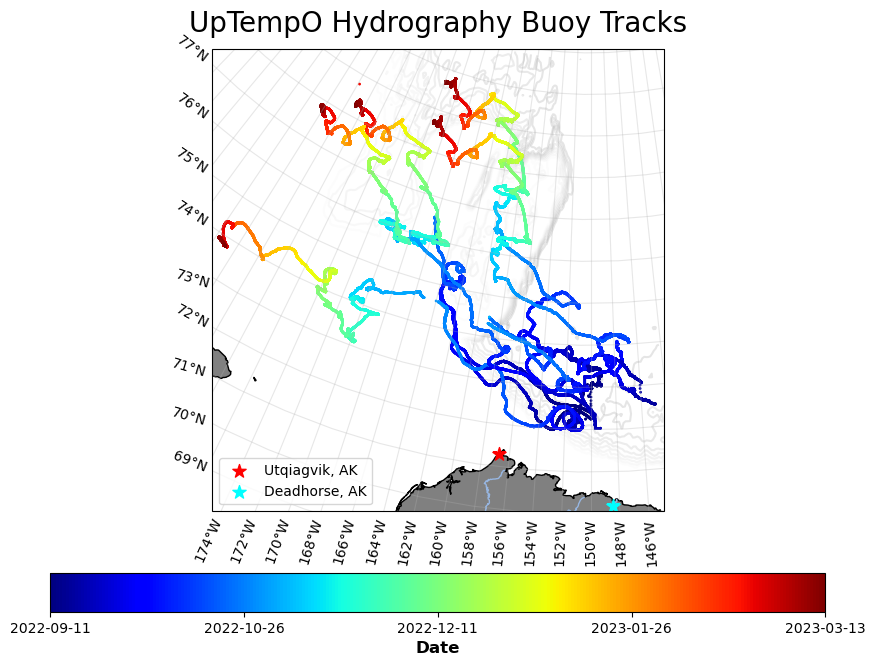

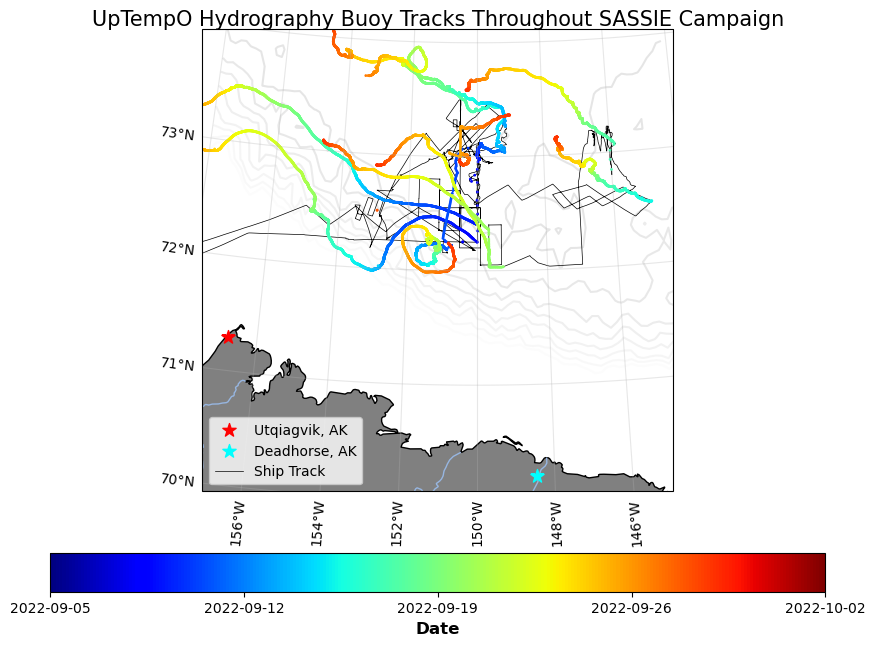

In [9]:
map_uptempo('all_data',ship_track=False)   
map_uptempo('campaign_data')   


In [23]:
def define_var_attributes(var):
    if var =='salinity':
        colormap = 'viridis'
        var_label = 'Salinity'
    if var =='temperature':
        colormap = 'plasma'
        var_label = 'Water Temperature ($^{\circ}$C)'
    return colormap,var_label

In [24]:
## USE FOR DATA VARIABLES WITH A DEPTH DIMENSION 
def plot_uptempo_data(buoy,var,var_min,var_max):
    
    colormap,var_label = define_var_attributes(var)

    #GET UPTEMPO DATA
    file = files[buoy-1]
    ds = xr.open_dataset(file)
    dates = pd.to_datetime(ds.time.values).date
    deployment_date = dates[0]
    lat = np.squeeze(ds['latitude'])
    lon = np.squeeze(ds['longitude'])
    
    #Since the temp and salinity variables are different in each file, this searches for temp and salinity at each possible depth
    #and creates a dictionary entry if that variable exists. 
    var_dict= {}
    depth_dict={}
    if var == 'temperature':
        possible_depths = ['0014','0044','0500','6000','5000','4000','3500','3000','2500','2000','1500','1000','0750','0250','0025','0075']
        for depth in possible_depths:
            try:
                var_dict['ut_temp'+depth] = np.squeeze(ds['temperature'+depth].values)
                depth_dict['ut_depth'+depth] = float(depth[0:2]+'.'+depth[2:4])
            except:
                pass
    if var == 'salinity':
        possible_depths = ['0038','6000','4000','3000','2000','1000','0500','0051']
        for depth in possible_depths:
            try:
                var_dict['ut_sal'+depth] = np.squeeze(ds['salinity'+depth].values)
                depth_dict['ut_depth'+depth] = float(depth[0:2]+'.'+depth[2:4])
            except:
                pass  
    sorted_depth_dict = dict(sorted(depth_dict.items(), key=lambda x:x[0]))
    sorted_var_dict = dict(sorted(var_dict.items(), key=lambda x:x[0]))
   
    ##CONFIGURE UPTEMPO DATA INTO NUMPY ARRAYS
    number_of_measurements = len(depth_dict)
    depths = list(sorted_depth_dict.values())
    var_at_depths = list(sorted_var_dict.values())
    
    var_arr = np.zeros((lat.size,number_of_measurements))
    z = np.zeros((lat.size,number_of_measurements))
    
    #Bouys 2,6, and 7 took salinity measurements at only one depth, 
    #so some of the steps used for other cases are unecessary and cause exception
    if (var == 'salinity')&((buoy==2)|(buoy==6)|(buoy==7)):
        all_lat = lat.values
        all_lon = lon.values
        flat_z = np.squeeze(np.full((lat.size,1), depths))
        flat_arr = var_at_depths
    else:
        for i in np.arange(0,number_of_measurements,1):
            z[:,i] = np.squeeze(np.full((lat.size,1), depths[i]))
            var_arr[:,i] = var_at_depths[i]
        flat_z = z.flatten(order='F')
        flat_arr = var_arr.flatten(order='F')
        all_lon = np.squeeze(np.tile(lon.values,(1,number_of_measurements)))
        all_lat = np.squeeze(np.tile(lat.values,(1,number_of_measurements)))
        
    ##CREATE THE 3D PLOT 
    latmin = min(lat.values)
    latmax = max(lat.values)
    lonmin = min(lon.values)
    if (buoy == 4)|(buoy==9): 
        lonmax = -150
    else: 
        lonmax = max(lon.values)

    if (var == 'salinity')&((buoy==2)|(buoy==6)|(buoy==7)):
        dmin = 0
        dmax = 0.5
    else:
        dmin = min(depths)
        dmax = max(depths)
        
   
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection='3d',computed_zorder=False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.set_xlim(lonmin, lonmax); ax.set_ylim(latmin,latmax); ax.set_zlim(dmin,dmax);
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    xticks = list(np.linspace(lonmin,lonmax,4))
    ax.set_xticks(np.around(xticks,2))
    yticks = list(np.linspace(latmin,latmax,4))
    ax.set_yticks(np.around(yticks,2))
    ax.set_zticks(depths)
    ax.set_xlabel('Longitude',fontsize=15)
    ax.set_ylabel('Latitude',fontsize=15)
    ax.set_zlabel('Depth (m)',fontsize=15)
    ax.view_init(195, 70)

    ax.set_title('Buoy'+ ' '+str(buoy)+' '+var_label+' Measurements',fontsize=20)
    
    #APPLY UPTEMPO DATA
    a = ax.scatter(all_lon,all_lat,flat_z,c=(flat_arr),cmap = colormap,s=0.5,zorder=1,vmin = var_min,vmax = var_max)
    
    fig.colorbar(a).set_label(label=var_label,size=15,weight='bold')
   
        
    ##SAVE FIGURE
    if not os.path.exists(fig_dir+var):
        os.makedirs(fig_dir+var)
    print('Saving Output Image:  '+fig_dir+var+'/UpTempO_Buoy'+'_'+str(buoy)+'_'+var+'.png')
    plt.savefig(fig_dir+var+'/UpTempO_Buoy'+'_'+str(buoy)+'_'+var+'.png',dpi='figure',format='png')
    

Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/uptempo/temperature/UpTempO_Buoy_3_temperature.png


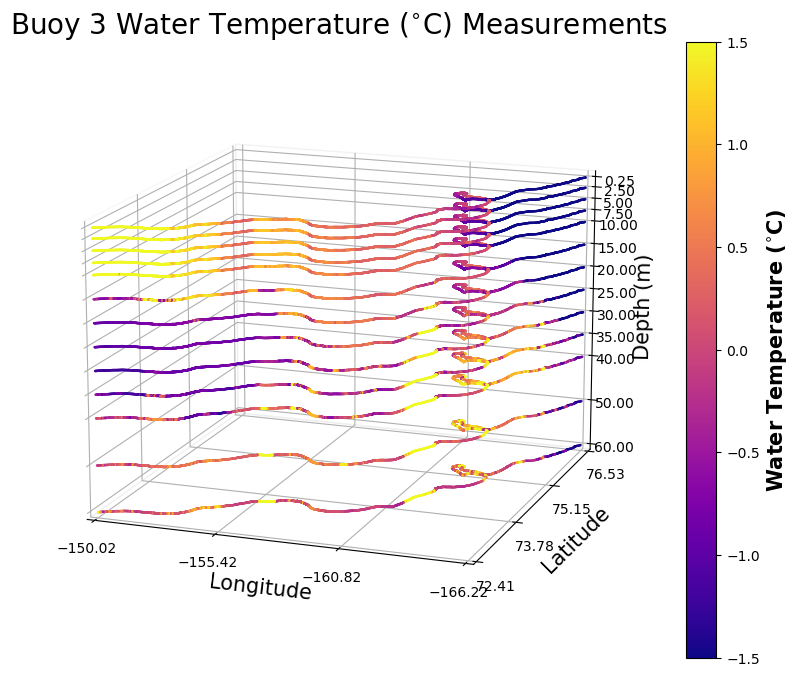

In [25]:
plot_uptempo_data(3,'temperature',-1.5,1.5)

Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/uptempo/salinity/UpTempO_Buoy_1_salinity.png
Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/uptempo/salinity/UpTempO_Buoy_2_salinity.png
Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/uptempo/salinity/UpTempO_Buoy_3_salinity.png
Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/uptempo/salinity/UpTempO_Buoy_4_salinity.png
Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/uptempo/salinity/UpTempO_Buoy_5_salinity.png
Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/uptempo/salinity/UpTempO_Buoy_6_salin

/var/folders/qz/9ktkgd290_52rhvjdnzz3f9mzx6b_9/T/ipykernel_87007/3750429684.py:84: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax.set_xlim(lonmin, lonmax); ax.set_ylim(latmin,latmax); ax.set_zlim(dmin,dmax);


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/uptempo/salinity/UpTempO_Buoy_8_salinity.png
Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/uptempo/salinity/UpTempO_Buoy_9_salinity.png


/var/folders/qz/9ktkgd290_52rhvjdnzz3f9mzx6b_9/T/ipykernel_87007/3750429684.py:84: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax.set_xlim(lonmin, lonmax); ax.set_ylim(latmin,latmax); ax.set_zlim(dmin,dmax);
/var/folders/qz/9ktkgd290_52rhvjdnzz3f9mzx6b_9/T/ipykernel_87007/3750429684.py:84: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax.set_xlim(lonmin, lonmax); ax.set_ylim(latmin,latmax); ax.set_zlim(dmin,dmax);


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/uptempo/salinity/UpTempO_Buoy_10_salinity.png
Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/uptempo/salinity/UpTempO_Buoy_11_salinity.png


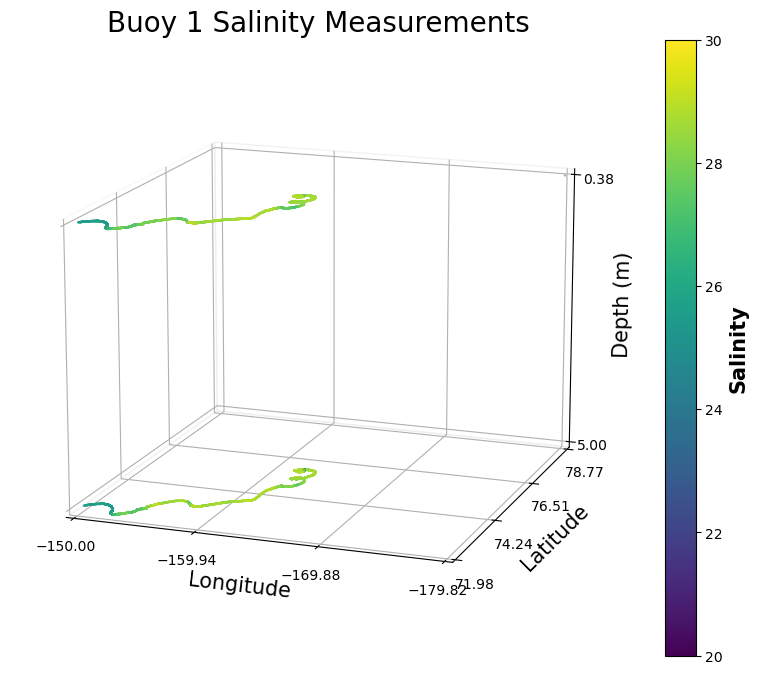

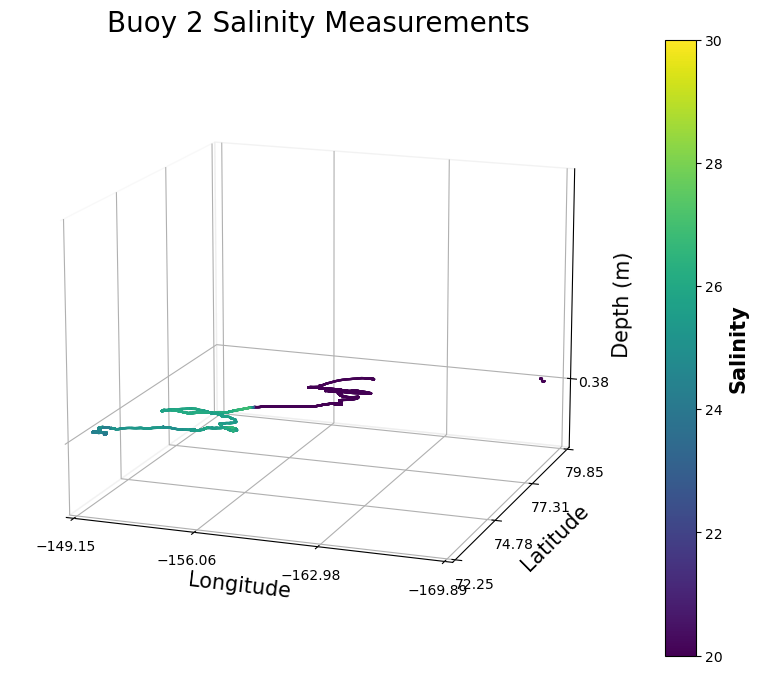

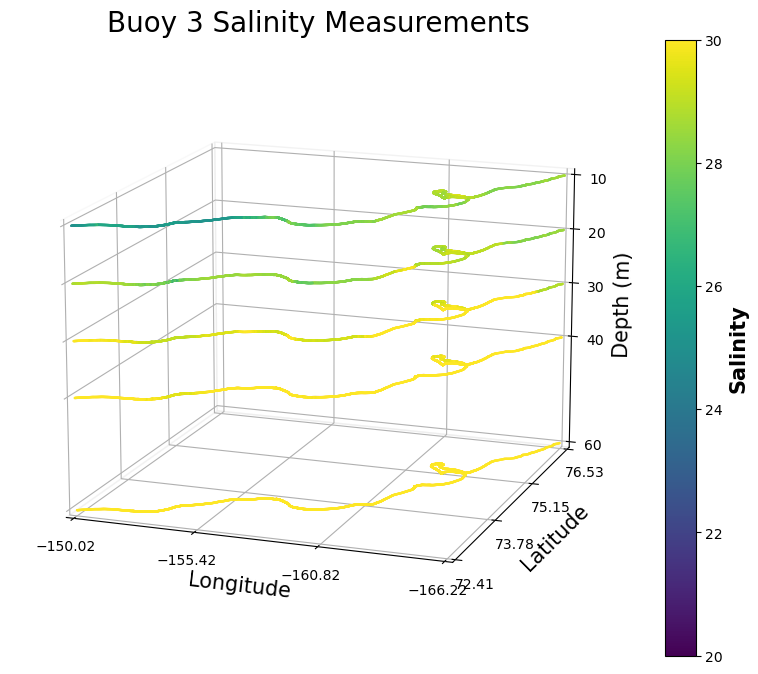

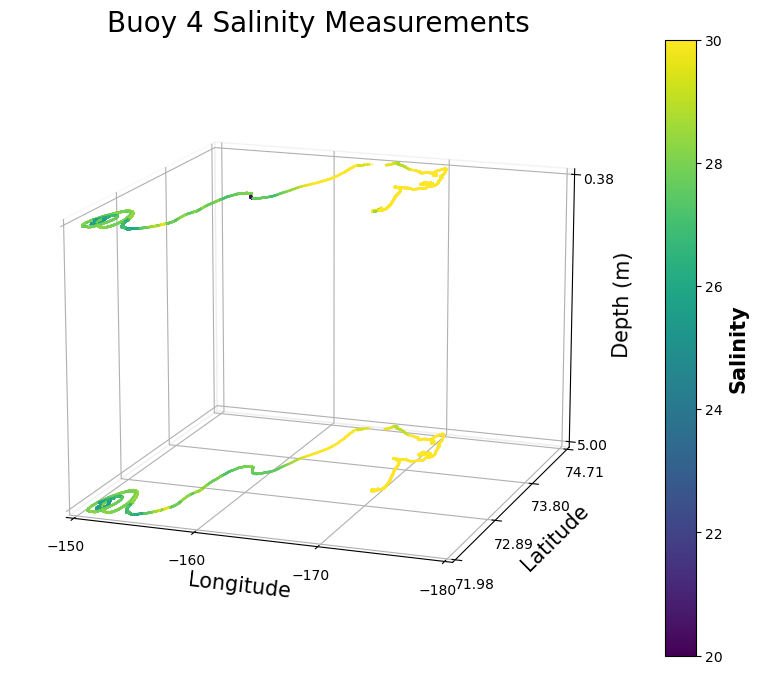

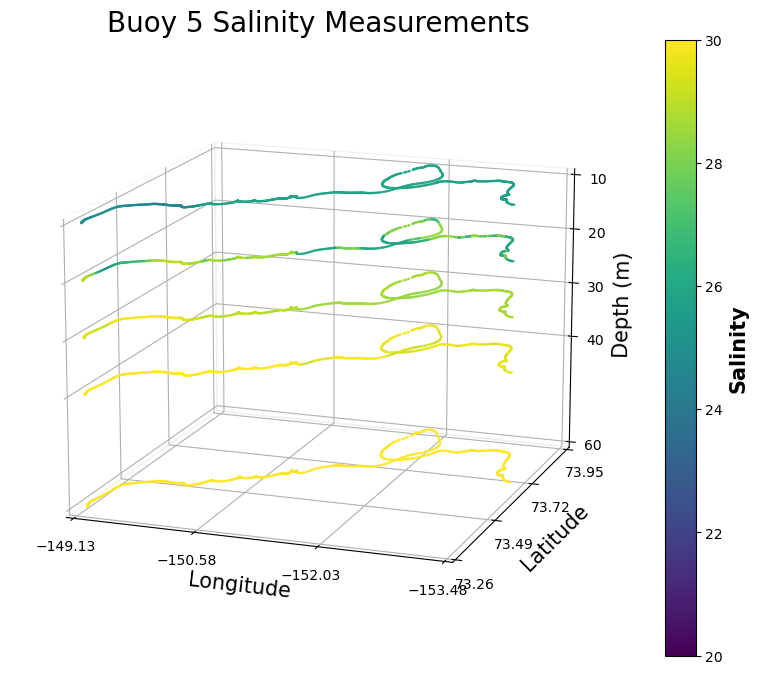

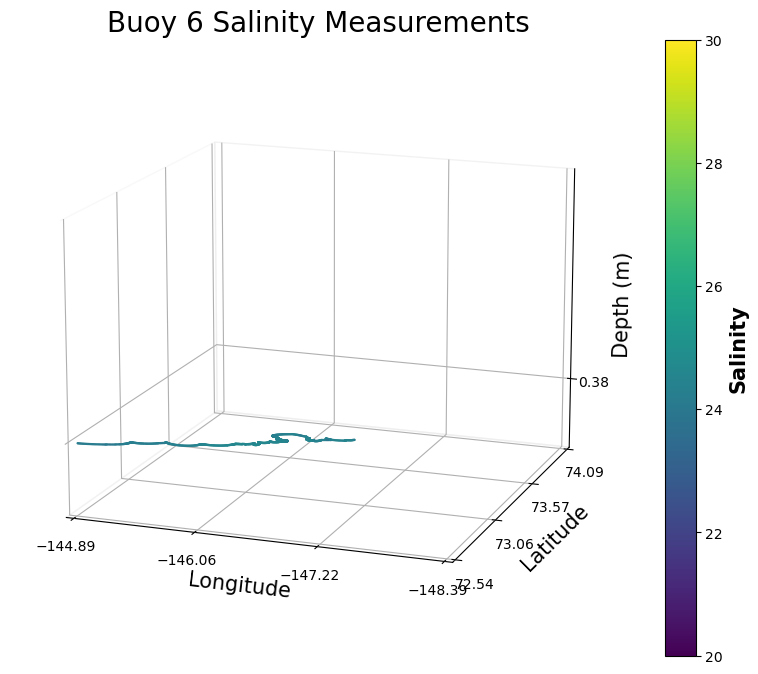

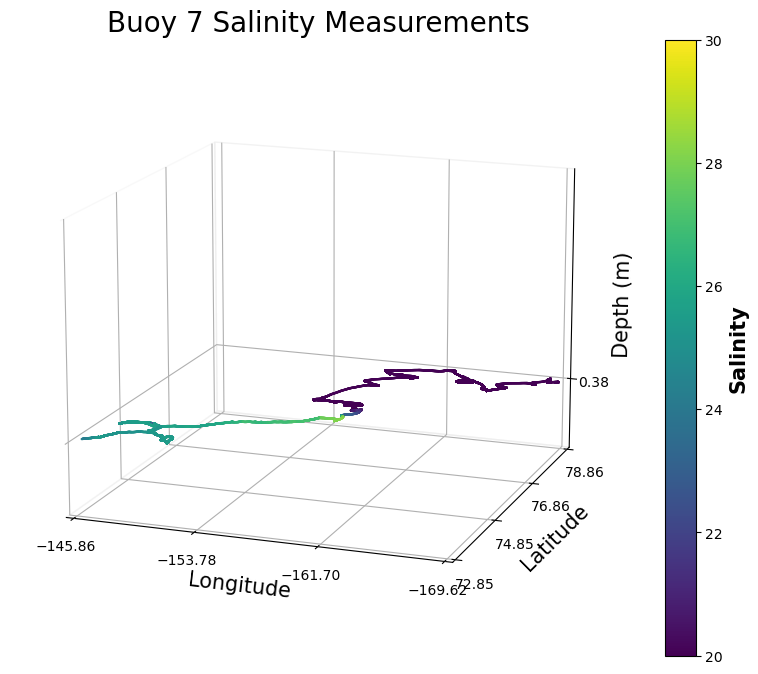

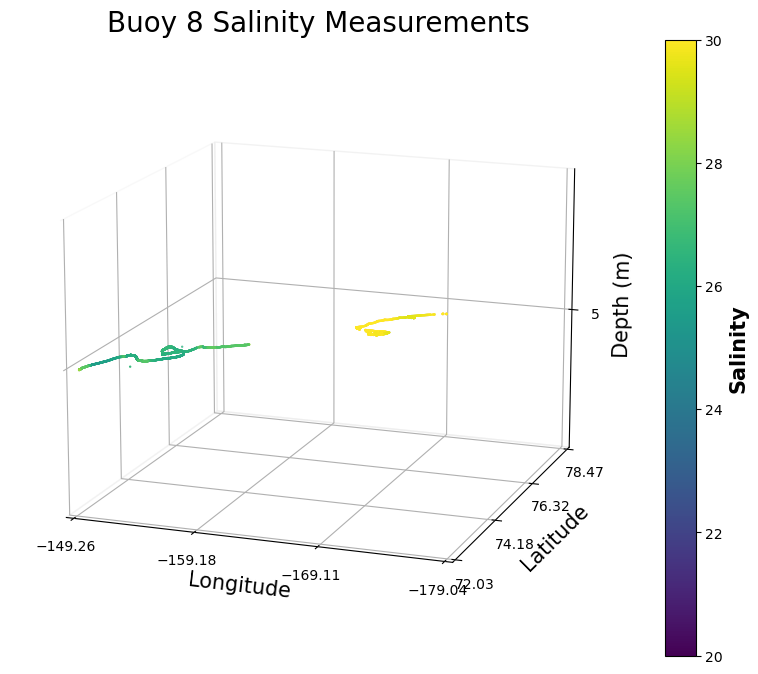

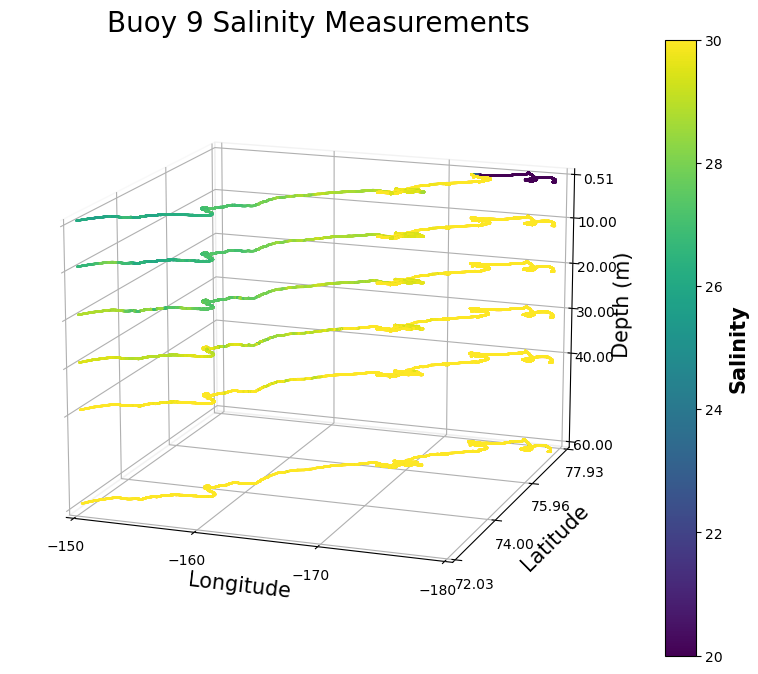

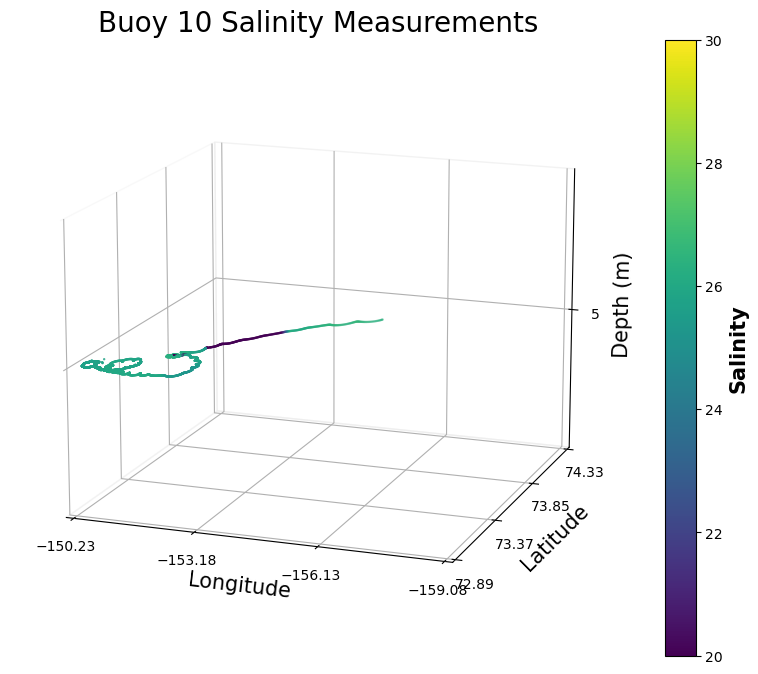

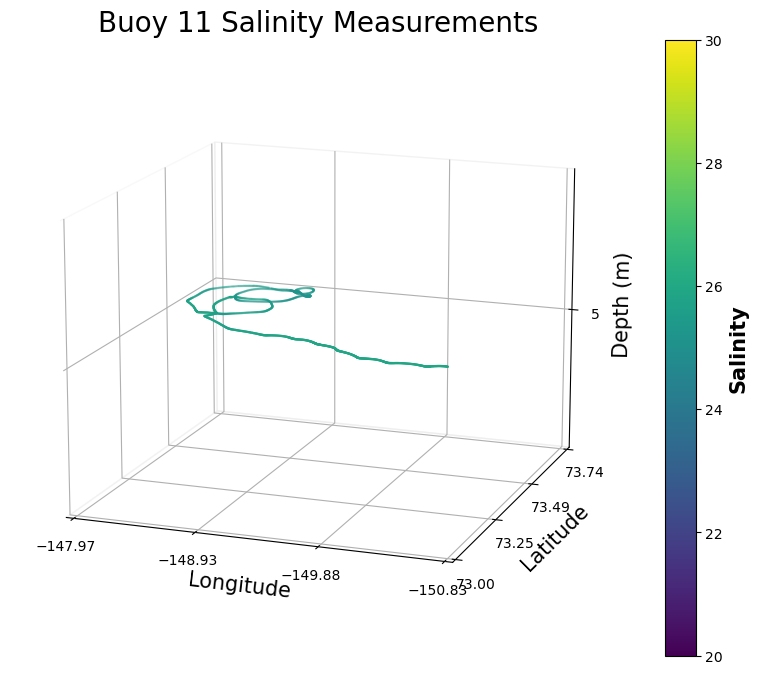

In [21]:
plot_uptempo_data(1,'salinity',20,30)
plot_uptempo_data(2,'salinity',20,30)
plot_uptempo_data(3,'salinity',20,30)
plot_uptempo_data(4,'salinity',20,30)
plot_uptempo_data(5,'salinity',20,30)
plot_uptempo_data(6,'salinity',20,30)
plot_uptempo_data(7,'salinity',20,30)
plot_uptempo_data(8,'salinity',20,30)
plot_uptempo_data(9,'salinity',20,30)
plot_uptempo_data(10,'salinity',20,30)
plot_uptempo_data(11,'salinity',20,30)

Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/uptempo/temperature/UpTempO_Buoy_1_temperature.png
Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/uptempo/temperature/UpTempO_Buoy_2_temperature.png
Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/uptempo/temperature/UpTempO_Buoy_3_temperature.png
Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/uptempo/temperature/UpTempO_Buoy_4_temperature.png
Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/uptempo/temperature/UpTempO_Buoy_5_temperature.png
Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/uptempo

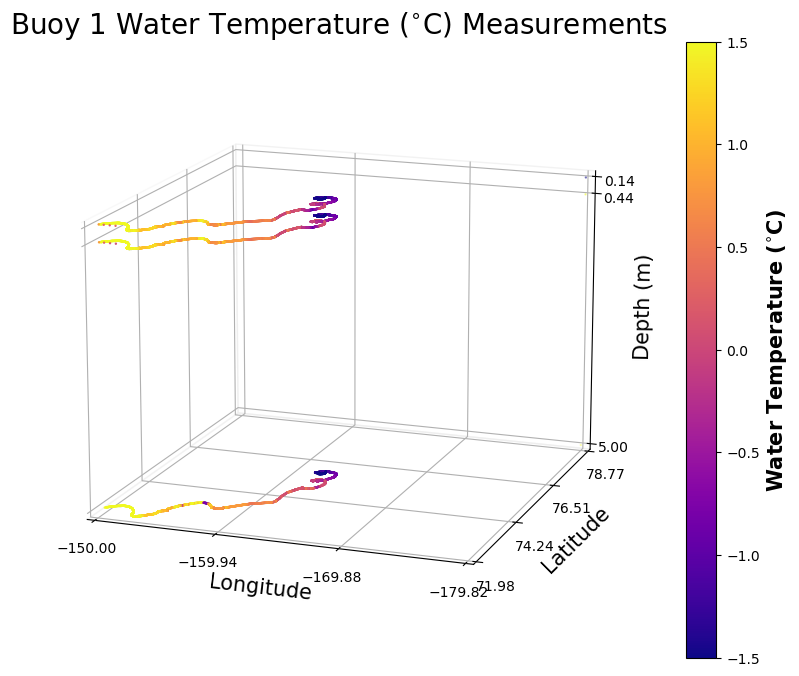

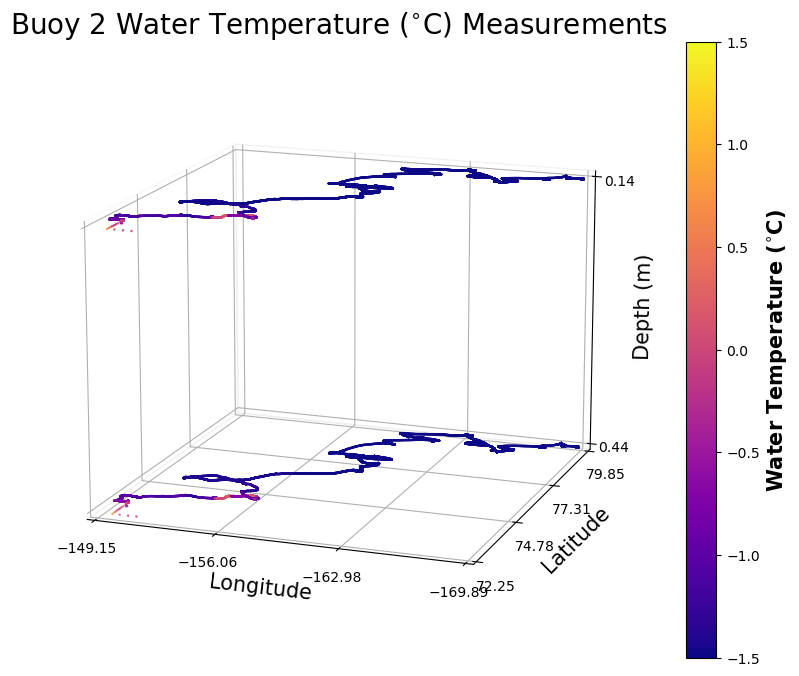

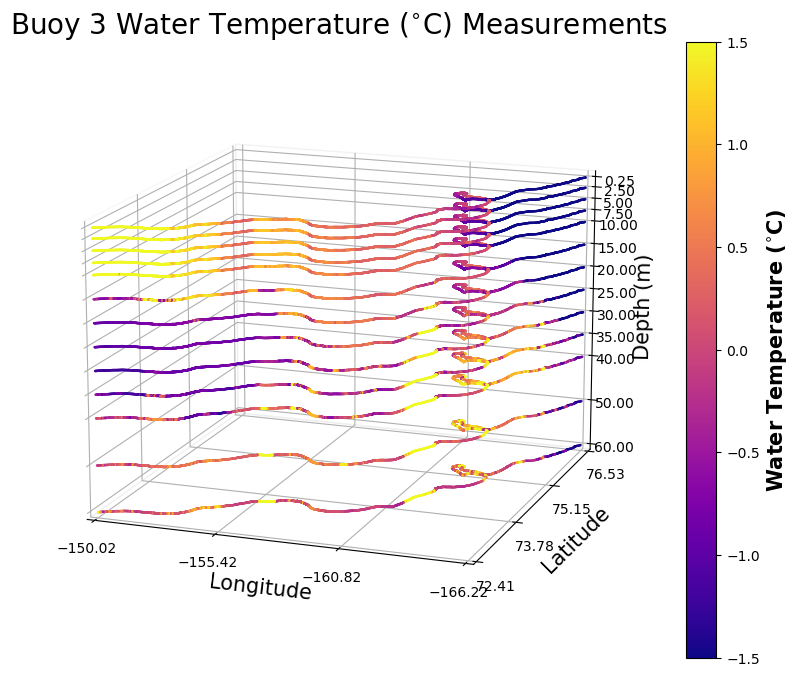

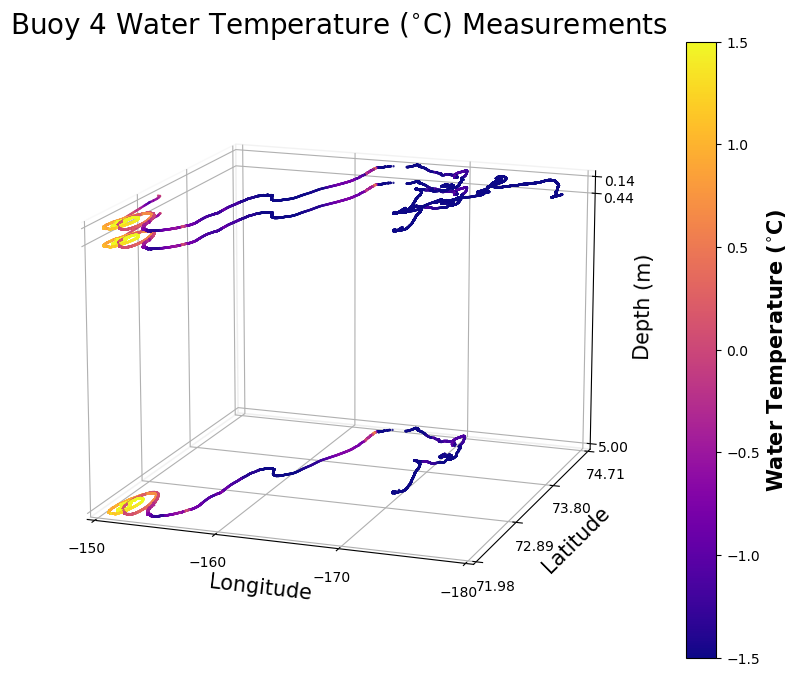

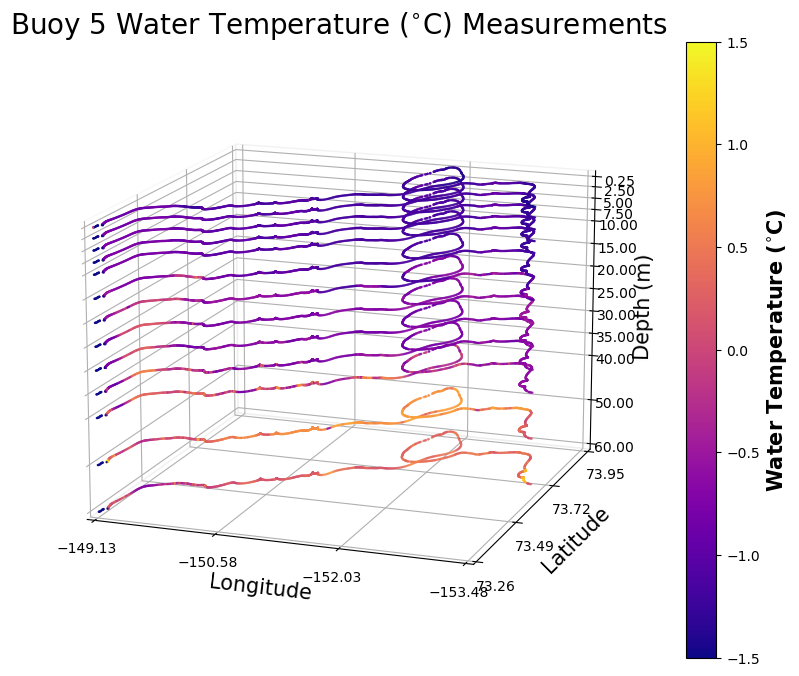

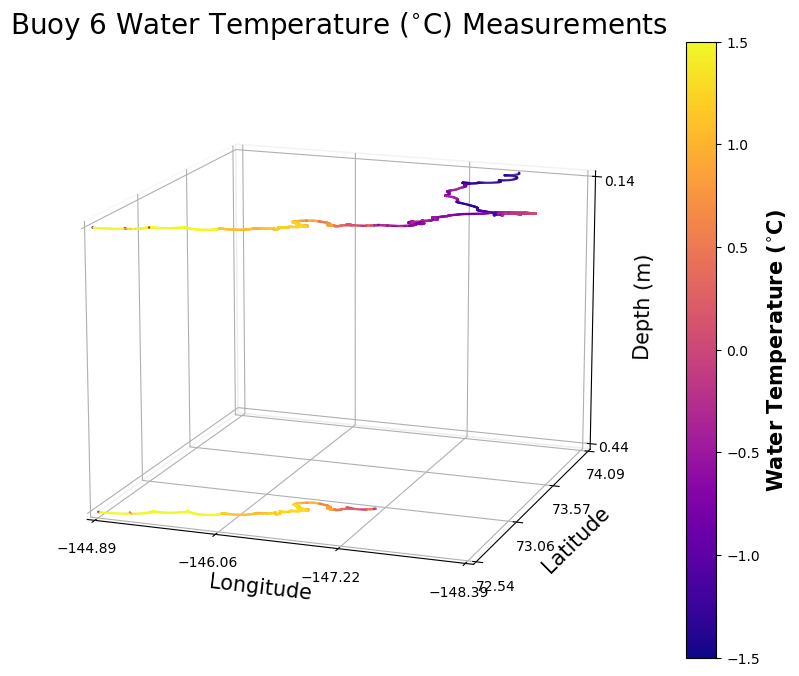

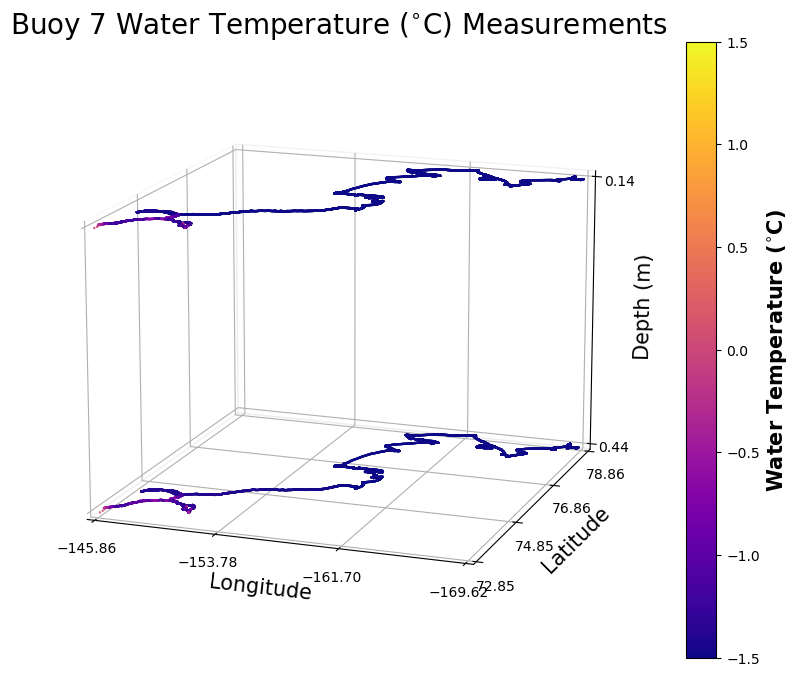

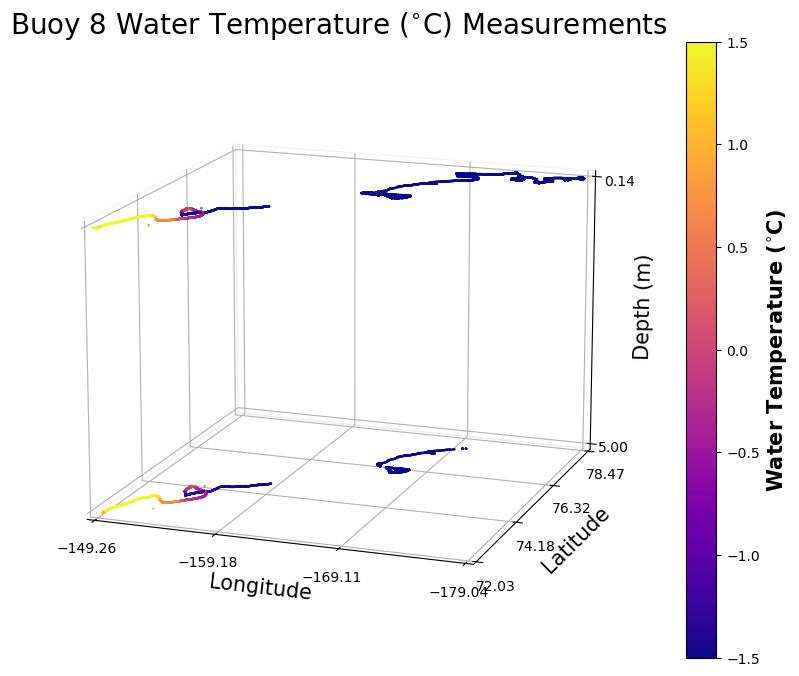

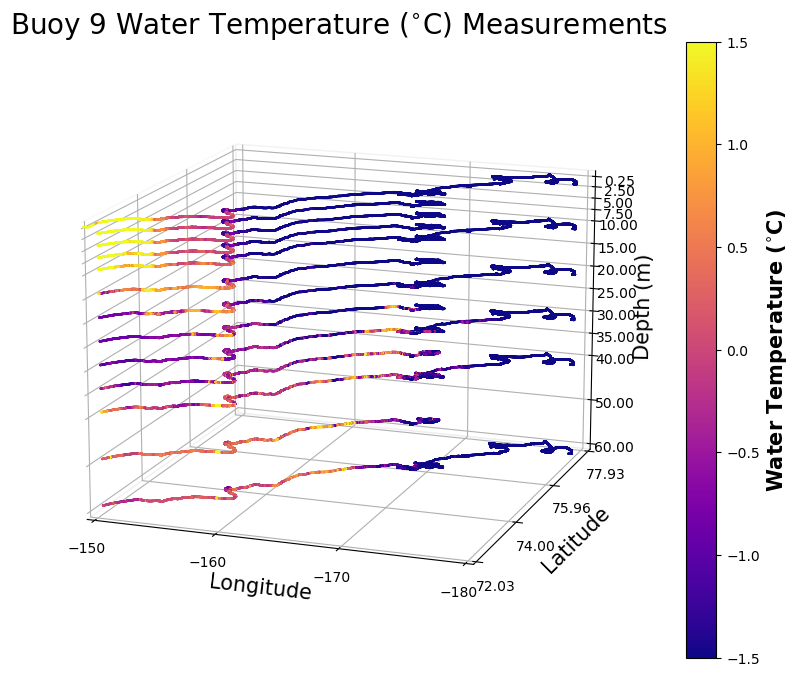

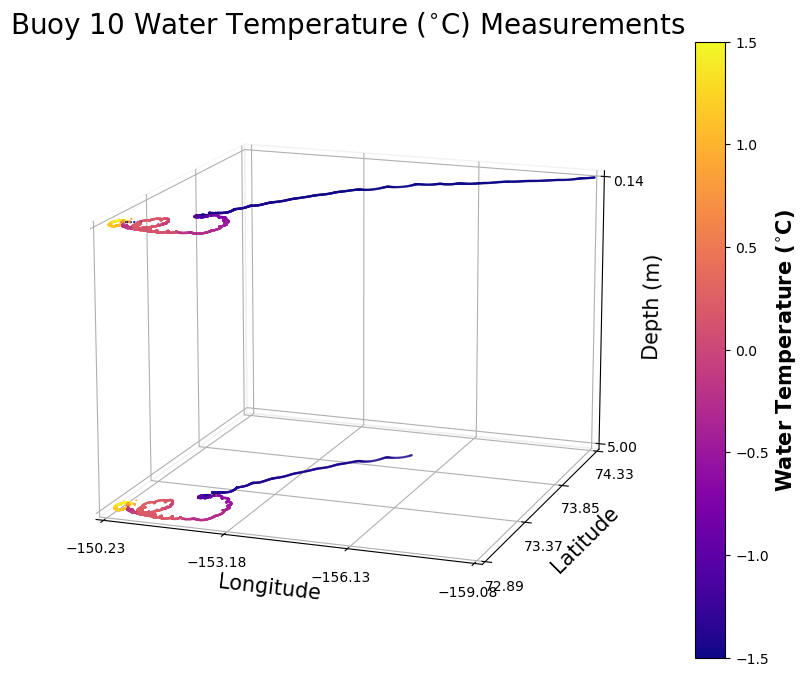

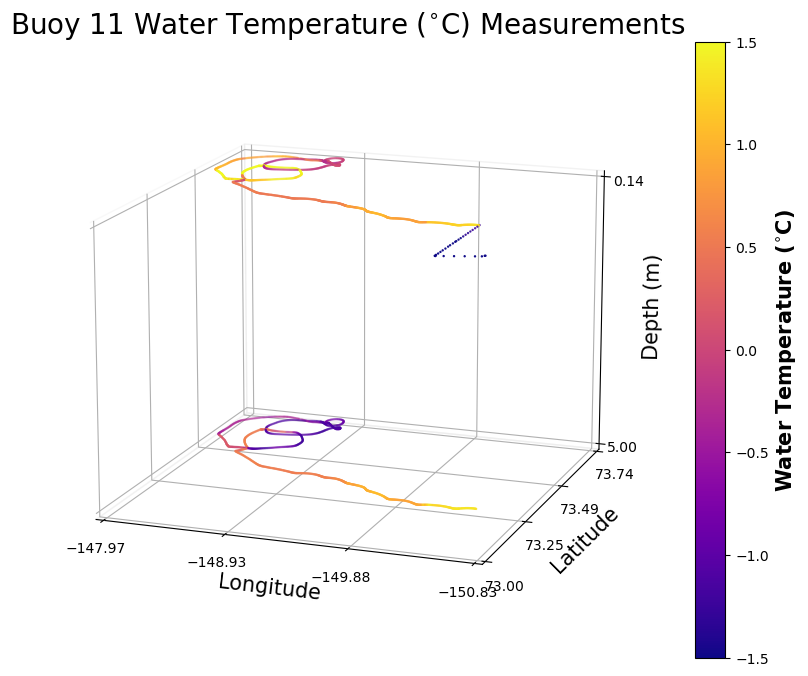

In [22]:
plot_uptempo_data(1,'temperature',-1.5,1.5)
plot_uptempo_data(2,'temperature',-1.5,1.5)
plot_uptempo_data(3,'temperature',-1.5,1.5)
plot_uptempo_data(4,'temperature',-1.5,1.5)
plot_uptempo_data(5,'temperature',-1.5,1.5)
plot_uptempo_data(6,'temperature',-1.5,1.5)
plot_uptempo_data(7,'temperature',-1.5,1.5)
plot_uptempo_data(8,'temperature',-1.5,1.5)
plot_uptempo_data(9,'temperature',-1.5,1.5)
plot_uptempo_data(10,'temperature',-1.5,1.5)
plot_uptempo_data(11,'temperature',-1.5,1.5)